## Eightball Parameter Tuning
We'll return to the Titanic data set to show some examples of how to perform parameter tuning with eightball

In [1]:
from eightball import model
from eightball import preprocessor 

import pandas as pd
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

For simplicity we'll only consider numeric features in this example

In [2]:
df_train = pd.read_csv('train.csv', index_col='PassengerId')
df_train_only_numeric = df_train[['Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'Survived']].copy()

Let's start with an out-of-the-box RandomForest classifier. Later in this example we'll tune `n_estimators`, `min_samples_split`, and `max_features`. The out-of-the-box default values are 10, 2, and "auto".

In [3]:
clf = RandomForestClassifier()
eightball_model = model.Model(clf, df_train_only_numeric, target_column='Survived', imputer_='most_frequent')
eightball_model.evaluate(scoring='accuracy')
eightball_model.eval_results.print_scores()

accuracy: 0.6812566693867302 +/- 0.024713194744053747


In [4]:
print 'n_estimators: %s' % eightball_model.clf.n_estimators
print 'min_samples_split: %s' % eightball_model.clf.min_samples_split
print 'max_features: %s' % eightball_model.clf.max_features

n_estimators: 10
min_samples_split: 2
max_features: auto


The eightball model object includes a `grid_search` method. `grid_search` needs a `param_grid` dictionary and a scoring method. The `param_grid` dictionary includes the name of the parameters to test and a list of values for each of those parameters. Running `grid_search` returns a `GridScores` object, which is added as a model attribute named `grid_scores`. The `grid_scores` object includes two plotting methods: `plot` and `plot_heat_map`; the former for plotting a single parameter, and the latter for plotting 2D grids for 2 to 3 parameters.

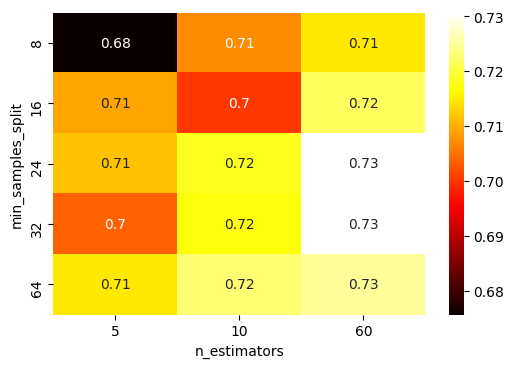

In [5]:
param_grid = {
    'n_estimators': [5, 10, 60],
    'min_samples_split': [8, 16, 24, 32, 64]
}
len(param_grid)
eightball_model.grid_search(param_grid=param_grid, scoring='accuracy')
eightball_model.grid_scores.plot_heat_map(metric='mean_test_score')

Each cell in this heatmap represents the mean CV score for the given parameter. We can also plot 'mean_score_time' or 'std_test_score'

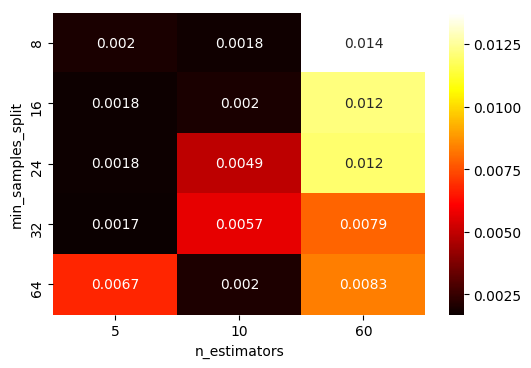

In [6]:
eightball_model.grid_scores.plot_heat_map(metric='mean_score_time')

and include the marginal values averaged across rows and columns

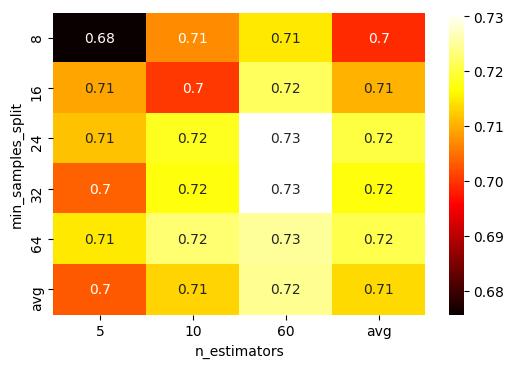

In [7]:
eightball_model.grid_scores.plot_heat_map(metric='mean_test_score', margins=True)

A heatmap plot of CV scores are also available up to 3 sets of model parameters. In this case, each pair of parameters is plotted (a total of 3 plots), and, by default, each plot is a slice of the cube that contains the optimal parameter value. `plot_heat_map` also gives the option to plot an "average" slice where each plot is averaged across the third parameter. This can be done by setting `reduce_by='avg'`. If you want your model to use the best set of parameters from `grid_search`, set `use_best=True`. Setting `use_best=True` will update the classifier and re-fit the model using the best set of params.

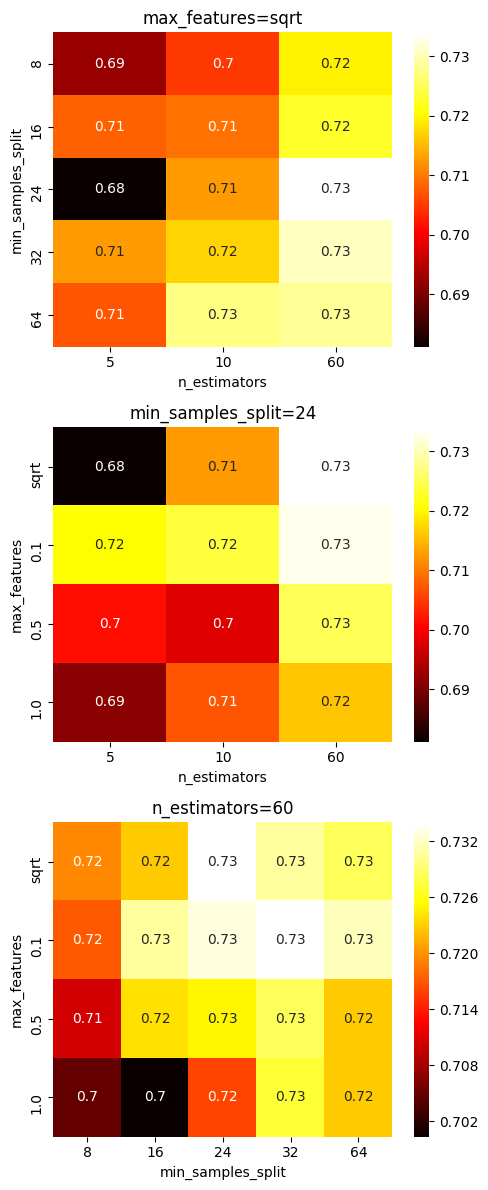

In [8]:
param_grid = {
    'n_estimators': [5, 10, 60],
    'min_samples_split': [8, 16, 24, 32, 64],
    'max_features': ['sqrt', 0.1, 0.5, 1.0]
}
eightball_model.grid_search(param_grid=param_grid, scoring='accuracy', use_best=True)
eightball_model.grid_scores.plot_heat_map(metric='mean_test_score')

In [9]:
print 'n_estimators: %s' % eightball_model.clf.n_estimators
print 'min_samples_split: %s' % eightball_model.clf.min_samples_split
print 'max_features: %s' % eightball_model.clf.max_features

n_estimators: 60
min_samples_split: 24
max_features: sqrt


Running `evaluate` with these new model params shows a significant improvement in the model's accuracy.

In [10]:
eightball_model.evaluate(scoring='accuracy')
eightball_model.eval_results.print_scores()

accuracy: 0.731768250580629 +/- 0.011838603686671507


Eightball also includes an experimental method, `param_optimization`, that attempts to automatically find an optimal set of parameters. This method takes a set of parameter bounds (`param_bounds`) and a scoring method. `param_bounds` is a dictionary of parameters to optimize with a tuple giving bounds as (min_param_value, max_param_value, min_step_size). 

As an example, suppose we want to optimize the `min_samples_split` and `max_features` parameters. We suspect that the optimal values for `min_samples_split` lies between 2 and 65 and assume the optimal value for `max_features` lies somewhere between 0.1 and 0.9. We want `param_optimization` to keep searching for a better parameter until the distance from the optimal value of `min_samples_split` is within 2 and the distance from the optimal value of `max_features` is within 0.05. In this case our param_bounds dictionary will look like:

In [11]:
param_bounds = {
    'max_features': (0.1, 0.9, 0.05),
    'min_samples_split': (2, 66, 1)
}

With these bounds, `param_optimization` will start by searching the 3x3 param grid of parameter pairs, with corners containing the bounding parameters, and the center half way between each param's lower and upper bound. Initially the distance between cells in this 3x3 grid (the "step size") will be (0.4, 32). Once `param_optimization` finds a local optimum with this initial step size, it will reduce the step size by half (to (0.25, 16), and continue looking for a local optimum. It will continue searching for a local optimum -> reducing step size until the step size is less than or equal to the min step size defined in param_bounds ((0.05, 1) in our case). The parameter values of the local optimum found with this min step size are considered "best". setting `verbose=True` will print the optimal value and step size at each iteration.

In [12]:
eightball_model.set_clf(RandomForestClassifier(n_estimators=60))
eightball_model.param_optimization(param_bounds=param_bounds, scoring='accuracy', use_best=True, verbose=True)

print 'n_estimators: %s' % eightball_model.clf.n_estimators
print 'min_samples_split: %s' % eightball_model.clf.min_samples_split
print 'max_features: %s' % eightball_model.clf.max_features

['max_features', 'min_samples_split']
[0.5, 34]
	step_size: [0.4, 32]
['max_features', 'min_samples_split']
[0.5, 34]
	step_sizes: [0.4, 32]
	new_scores_count: 9
	best_score: 0.7216182286108843
['max_features', 'min_samples_split']
(0.1, 34)
	step_sizes: [0.4, 32]
	new_scores_count: 0
	best_score: 0.7216182286108843
['max_features', 'min_samples_split']
(0.1, 34)
	step_sizes: [0.2, 16]
	new_scores_count: 5
	best_score: 0.7294457347310276
['max_features', 'min_samples_split']
(0.1, 50)
	step_sizes: [0.2, 16]
	new_scores_count: 1
	best_score: 0.7294457347310276
['max_features', 'min_samples_split']
(0.1, 50)
	step_sizes: [0.2, 16]
	new_scores_count: 0
	best_score: 0.7294457347310276
['max_features', 'min_samples_split']
(0.1, 50)
	step_sizes: [0.1, 8]
	new_scores_count: 5
	best_score: 0.7294457347310276
['max_features', 'min_samples_split']
(0.1, 50)
	step_sizes: [0.1, 8]
	new_scores_count: 0
	best_score: 0.7294457347310276
['max_features', 'min_samples_split']
(0.1, 50)
	step_sizes: [0.

In [13]:
eightball_model.evaluate(scoring='accuracy')
eightball_model.eval_results.print_scores()

accuracy: 0.727273868558157 +/- 0.013539431622965942


There isn't a limit to the number of parameters that can be passed to `param_optimization` via `param_bounds`. If, for instance, `param_bounds` included 3 parameters, `param_optimization` would search a 3x3x3 cube at each iteration. If `param_bounds` included 4 parameters, `param_optimization` would search a 3x3x3x3 hyper-cube at each iteration. Note, however, that the number of CV tests required at each iteration increases exponentially with each additional parameter. Which means each additional parameter you include will substantially increase the time it takes for `param_optimization` to finish.